#**Loading the Data**

In [2]:
# Access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import pandas
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/grants.csv'
df = pd.read_csv(file_path)

# Display the first few rows
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Unnamed: 0,opportunity_id,opportunity_title,opportunity_number,opportunity_category,funding_instrument_type,category_of_funding_activity,cfda_numbers,eligible_applicants,eligible_applicants_type,...,post_date,close_date,last_updated_date,archive_date,award_ceiling,award_floor,estimated_total_program_funding,expected_number_of_awards,cost_sharing_or_matching_requirement,additional_information_url
0,0,262148,Establishment of the Edmund S. Muskie Graduate...,SCAPPD-14-AW-161-SCA-08152014,Discretionary,Cooperative Agreement,Other,19.040,Others,Non-Government Organization,...,2014-08-15,2014-09-04,2014-08-20,2014-10-04,600000.0,400000.0,600000.0,1.0,False,NaN
1,1,262308,Health and resiliency of salt marshes in Jamai...,NPS-14-NERO-0119,Discretionary,Cooperative Agreement,Other,15.945,Others,Non-Government Organization,...,2014-08-18,2014-08-23,2014-08-18,2014-08-24,275897.0,275897.0,275897.0,1.0,False,NaN
2,2,262368,Post-Hurricane Sandy submerged marine habitat ...,NPS-14-NERO-0125,Discretionary,Cooperative Agreement,Other,15.945,Others,Non-Government Organization,...,2014-08-19,2014-08-24,2014-08-19,2014-08-25,480000.0,480000.0,480000.0,1.0,False,NaN
3,3,262390,Inventory and Monitoring of Amphibians and Rep...,NPS-14-NERO-0087,Discretionary,Cooperative Agreement,Other,15.945,Others,Non-Government Organization,...,2014-08-19,2014-08-24,2014-08-19,2014-08-25,255577.0,255577.0,255577.0,1.0,False,NaN
4,4,131594,Youth Leadership Program with Algeria,ECA-PE-C-PY-12-09,Discretionary,Cooperative Agreement,Other,19.415,Others,Non-Government Organization,...,2011-11-21,2012-01-04,2011-11-21,2012-01-05,250000.0,NaN,250000.0,1.0,True,http://exchanges.state.gov/grants/open2.html


#**Preprocessing**

In [4]:
# Import the necessary modules
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Drop rows with missing values in the relevant columns
df = df.dropna(subset=['opportunity_title', 'category_of_funding_activity'])

# Define the features and target
texts = df['opportunity_title'].astype(str).values
labels = df['category_of_funding_activity'].astype(str).values

# Tokenize and convert text to sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to ensure uniform input size
max_sequence_length = 150  # average title length
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Number of categories: {len(label_encoder.classes_)}")


Training samples: 60512, Testing samples: 15128
Number of categories: 26


#**RNN Model**

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,          # Stop after 3 epochs with no improvement
    restore_best_weights=True,
    verbose=1
)

# Define an improved model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_length),
    LSTM(64, return_sequences=False),
    Dropout(0.6),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/15
1891/1891 [==============================] - 124s 65ms/step - loss: 2.7704 - accuracy: 0.2786 - val_loss: 2.0968 - val_accuracy: 0.4336
Epoch 2/15
1891/1891 [==============================] - 122s 65ms/step - loss: 1.9996 - accuracy: 0.4348 - val_loss: 1.7297 - val_accuracy: 0.5290
Epoch 3/15
1891/1891 [==============================] - 121s 64ms/step - loss: 1.7101 - accuracy: 0.5343 - val_loss: 1.5567 - val_accuracy: 0.5911
Epoch 4/15
1891/1891 [==============================] - 123s 65ms/step - loss: 1.5573 - accuracy: 0.5788 - val_loss: 1.4745 - val_accuracy: 0.6040
Epoch 5/15
1891/1891 [==============================] - 122s 64ms/step - loss: 1.4521 - accuracy: 0.6079 - val_loss: 1.3997 - val_accuracy: 0.6167
Epoch 6/15
1891/1891 [==============================] - 122s 64ms/step - loss: 1.3765 - accuracy: 0.6258 - val_loss: 1.3470 - val_accuracy: 0.6367
Epoch 7/15
1891/1891 [==============================] - 121s 64ms/step - loss: 1.3114 - accuracy: 0.6435 - val_loss: 1

#**Visualize Training Progress**

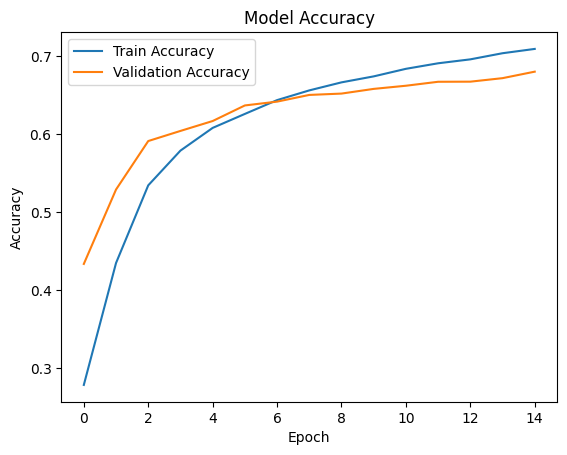

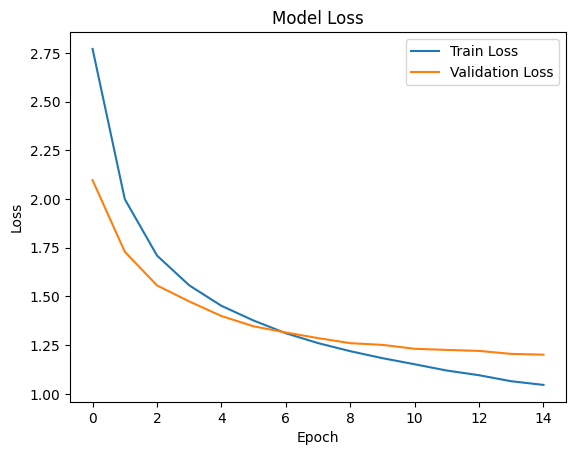

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


#**Evaluating the model**

In [8]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predict on new data
sample_titles = ["Improving healthcare access in rural areas", "Climate resilience research funding"]
sample_sequences = tokenizer.texts_to_sequences(sample_titles)
sample_padded = pad_sequences(sample_sequences, maxlen=max_sequence_length)
predictions = model.predict(sample_padded)
predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))

for title, category in zip(sample_titles, predicted_categories):
    print(f"Title: {title}\nPredicted Category: {category}\n")


473/473 [==============================] - 10s 21ms/step - loss: 1.2014 - accuracy: 0.6800
Test Loss: 1.2014, Test Accuracy: 0.6800
1/1 [==============================] - 0s 379ms/step
Title: Improving healthcare access in rural areas
Predicted Category: Health

Title: Climate resilience research funding
Predicted Category: Science and Technology and other Research and Development



#**Extended Evaluation**

In [9]:
# Define additional sample titles
sample_titles = [
    "Improving healthcare access in rural areas",
    "Climate resilience research funding",
    "Educational opportunities for underprivileged youth",
    "Research on renewable energy technologies",
    "Community safety and crime prevention programs",
    "Innovations in agricultural practices",
    "Advancements in artificial intelligence",
    "Support for small business development",
    "Ocean and marine life conservation projects",
    "Healthcare innovations for low-income communities"
]

# Tokenize and pad the sample titles
sample_sequences = tokenizer.texts_to_sequences(sample_titles)
sample_padded = pad_sequences(sample_sequences, maxlen=max_sequence_length)

# Predict categories for the sample titles
predictions = model.predict(sample_padded)
predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Display the results
for title, category in zip(sample_titles, predicted_categories):
    print(f"Title: {title}\nPredicted Category: {category}\n")


1/1 [==============================] - 0s 34ms/step
Title: Improving healthcare access in rural areas
Predicted Category: Health

Title: Climate resilience research funding
Predicted Category: Science and Technology and other Research and Development

Title: Educational opportunities for underprivileged youth
Predicted Category: Education

Title: Research on renewable energy technologies
Predicted Category: Science and Technology and other Research and Development

Title: Community safety and crime prevention programs
Predicted Category: Law, Justice and Legal Services

Title: Innovations in agricultural practices
Predicted Category: Science and Technology and other Research and Development

Title: Advancements in artificial intelligence
Predicted Category: Science and Technology and other Research and Development

Title: Support for small business development
Predicted Category: Other

Title: Ocean and marine life conservation projects
Predicted Category: Natural Resources

Title: Hea

#**Validating Predictions Against Ground Truth**

In [10]:
from sklearn.metrics import classification_report, accuracy_score

# Generate predictions for the test dataset
test_predictions = model.predict(X_test)
predicted_indices = test_predictions.argmax(axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_indices)

# Convert ground truth labels (y_test) back to their category names
true_labels = label_encoder.inverse_transform(y_test)

# Compare predictions to ground truth
print("Validation Results:")
print(f"Accuracy: {accuracy_score(true_labels, predicted_labels):.4f}")

# Generate a detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))


473/473 [==============================] - 10s 21ms/step
Validation Results:
Accuracy: 0.6800

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                           precision    recall  f1-score   support

                                      Affordable Care Act       0.00      0.00      0.00        22
                                              Agriculture       0.16      0.05      0.07       221
                                                     Arts       0.00      0.00      0.00        85
                                    Business and Commerce       0.00      0.00      0.00        78
                                    Community Development       0.00      0.00      0.00       161
                                      Consumer Protection       0.00      0.00      0.00         6
                           Disaster Prevention and Relief       0.00      0.00      0.00        63
                                                Education       0.69      0.56      0.62       825
                           Employment, Labor and Training       0.00      0.00      0.00       191
         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#**Save Model**

In [11]:
# Save the model and tokenizer
model.save('rnn_funding_category_model_2.5.h5')

import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
